
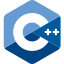
<br>

<div style="text-align:center; font-size:200%;">
 <b>Vector-Implementierung (V5, Templates)</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 20 Vector-Implementierung (V5, Templates).ipynb -->
<!-- slides/module_200_stl_collections/topic_135_my_vector_v5.cpp -->


## `MyVector`-Class

Mit Templates können wir den Code für verschiedene Typen wiederverwenden.

- Diese Implementierung orientiert sich näher an der Standardbibliothek als
  die früheren Versionen
  - Der reservierte Speicher wird erst bei Bedarf initialisiert
  - Elemente werden sofort zerstört, wenn sie aus dem Vektor entfernt werden
  - Der Vektor ist iterierbar
  - Die `at()`-Methode wirft eine `std::out_of_range`-Exception
  - ...
- Die Implementierung ist aber bei weitem nicht vollständig und nicht
  optimiert
- Es ist fast immer besser, die Standardbibliothek oder eine auf spezielle
  Anforderungen optimierte Bibliothek zu verwenden

In [ ]:
#include <algorithm>
#include <initializer_list>
#include <iostream>
#include <memory>
#include <sstream>
#include <stdexcept>
#include <utility>
#include <vector>

#include "lifetime_observer.hpp"
#include "type_name.hpp"

In [ ]:
using namespace std::string_literals;

In [ ]:
template <typename T>
class MyVector
{
public:
    using value_type = T;
    using size_type = std::size_t;
    using difference_type = std::ptrdiff_t;
    using pointer = T*; // or std::allocator_traits<std::allocator<T>>::pointer;
    using const_pointer = const T*;
    using reference = T&;
    using const_reference = const T&;
    using iterator = pointer;
    using const_iterator = const_pointer;

    MyVector() = default;
    explicit MyVector(size_type size, T value = T{});
    MyVector(std::initializer_list<T> init);

    MyVector(const MyVector& other)
        : size_(other.size_), capacity_(other.capacity_), data_(allocate_data())
    {
        for (size_type i{0}; i != size_; ++i) {
            allocator.construct(data_ + i, other.data_[i]);
        }
        std::cout << "MyVector<" << type_name<T>() << "> @" << this
                  << ": constructed (const MyVector&)\n";
    }

    MyVector& operator=(const MyVector& other)
    {
        if (this != &other) {
            delete_data();
            size_ = other.size_;
            capacity_ = other.capacity_;
            data_ = allocate_data();
            for (size_type i{0}; i != size_; ++i) {
                allocator.construct(data_ + i, other.data_[i]);
            }
        }
        std::cout << "MyVector<" << type_name<T>() << "> @" << this
                  << ": copy assignment called\n";
        return *this;
    }

    MyVector(MyVector&& other) noexcept
        : size_(other.size_), capacity_(other.capacity_), data_(other.data_)
    {
        // std::vector guarantees that `other` is `empty()` after move
        other.size_ = 0;
        other.capacity_ = 0;
        other.data_ = nullptr;
        std::cout << "MyVector<" << type_name<T>() << "> @" << this
                  << ": constructed (MyVector&&)\n";
    }

    MyVector& operator=(MyVector&& other) noexcept
    {
        delete_data();
        size_ = other.size_;
        capacity_ = other.capacity_;
        data_ = other.data_;
        // std::vector guarantees that `other` is `empty()` after move-assignment
        other.size_ = 0;
        other.capacity_ = 0;
        other.data_ = nullptr;
        std::cout << "MyVector<" << type_name<T>() << "> @" << this
                  << ": move assignment called\n";
        return *this;
    }

    ~MyVector();

    reference operator[](size_type index) { return data_[index]; }
    const_reference operator[](size_type index) const { return data_[index]; }

    iterator begin() { return data_; }
    const_iterator begin() const { return data_; }
    const_iterator cbegin() const { return data_; }

    iterator end() { return data_ + size_; }
    const_iterator end() const { return data_ + size_; }
    const_iterator cend() const { return data_ + size_; }

    reference front() { return data_[0]; }
    const_reference front() const { return data_[0]; }

    reference back() { return data_[size_ - 1]; }
    const_reference back() const { return data_[size_ - 1]; }

    void push_back(const T& value);
    void push_back(T&& value);
    void pop_back();

    template <typename... Arg>
    void emplace_back(Arg&&... args);

    reference at(size_type index);
    const_reference at(size_type index) const;

    size_type size() const;
    size_type capacity() const;
    void reserve(size_type new_size);

private:
    // In contrast to `std::vector`, we don't provide the allocator as a template
    // parameter, but use a static allocator instead
    static std::allocator<T> allocator;

    size_type size_{0};
    size_type capacity_{0};
    pointer data_{nullptr};

    void assert_valid_index(size_type index) const;
    void ensure_can_push_back();
    pointer allocate_data();
    void delete_data();
};

// Storage for the static allocator has to be provided outside the class declaration
template <typename T>
std::allocator<T> MyVector<T>::allocator{};

template <typename T>
std::ostream& operator<<(std::ostream& os, const MyVector<T>& vec)
{
    std::string sep{""};
    os << "[";
    for (typename MyVector<T>::size_type i{0}; i != vec.size(); ++i) {
        os << sep << vec.at(i);
        sep = ", "s;
    }
    os << "]";
    return os;
}


## `MyVector`-Implementierung

- Nachdem wir den Speicher in `data_` nicht initialisieren, müssen wir die
  Elemente mit dem Low-Level-`std::allocator`-Mechanismus konstruieren und
  zerstören

In [ ]:
template <typename T>
MyVector<T>::MyVector(size_type size, T value)
    : size_(size), capacity_(size), data_(allocate_data())
{
    std::cout << "MyVector<" << type_name<T>() << "> @" << this
              << ": constructed (size_type, T)\n";
    for (size_type i{0}; i != size_; ++i) {
        allocator.construct(data_ + i, value);
    }
}

In [ ]:
template <typename T>
MyVector<T>::MyVector(std::initializer_list<T> init)
    : size_(init.size()), capacity_(init.size()), data_(allocate_data())
{
    std::cout << "MyVector<" << type_name<T>() << "> @" << this
              << ": constructed (std::initializer_list)\n";
    auto* p{data_};
    for (const auto& elem : init) {
        allocator.construct(p++, elem);
    }
}

In [ ]:
template <typename T>
MyVector<T>::~MyVector()
{
    delete_data();
    std::cout << "MyVector<" << type_name<T>() << "> @" << this << ": destroyed\n";
}

In [ ]:
template <typename T>
void MyVector<T>::ensure_can_push_back()
{
    if (size_ == capacity_) {
        size_type new_capacity = capacity() == 0 ? 1 : capacity() * 2;
        reserve(new_capacity);
    }
}

In [ ]:
template <typename T>
typename MyVector<T>::pointer MyVector<T>::allocate_data()
{
    return allocator.allocate(capacity());
}

In [ ]:
template <typename T>
void MyVector<T>::delete_data()
{
    if (data_) {
        for (size_type i{0}; i != size_; ++i) {
            allocator.destroy(data_ + i);
        }
        allocator.deallocate(data_, capacity());
    }
    data_ = nullptr;
}

In [ ]:
template <typename T>
void MyVector<T>::assert_valid_index(size_type index) const
{
    if (index >= size_) {
        throw std::out_of_range("Index out of range");
    }
}

In [ ]:
template <typename T>
void MyVector<T>::push_back(const T& value)
{
    ensure_can_push_back();
    allocator.construct(data_ + size_, value);
    ++size_;
}

In [ ]:
template <typename T>
void MyVector<T>::push_back(T&& value)
{
    ensure_can_push_back();
    allocator.construct(data_ + size_, std::move(value));
    ++size_;
}

In [ ]:
template <typename T>
void MyVector<T>::pop_back()
{
    assert_valid_index(size_ - 1);
    --size_;
    allocator.destroy(data_ + size_);
}

In [ ]:
template <typename T>
template <typename... Arg>
void MyVector<T>::emplace_back(Arg&&... args)
{
    ensure_can_push_back();
    auto elt_ptr{data_ + size_};
    std::allocator_traits<decltype(allocator)>::construct(
        allocator, elt_ptr, std::forward<Arg>(args)...);
    ++size_;
}

In [ ]:
template <typename T>
typename MyVector<T>::reference MyVector<T>::at(size_type index)
{
    assert_valid_index(index);
    return data_[index];
}

In [ ]:
template <typename T>
typename MyVector<T>::const_reference MyVector<T>::at(size_type index) const
{
    assert_valid_index(index);
    return data_[index];
}

In [ ]:
template <typename T>
typename MyVector<T>::size_type MyVector<T>::size() const
{
    return size_;
}

In [ ]:
template <typename T>
typename MyVector<T>::size_type MyVector<T>::capacity() const
{
    return capacity_;
}

In [ ]:
template <typename T>
void MyVector<T>::reserve(size_type new_size)
{
    if (new_size > capacity_) {
        pointer new_data{allocator.allocate(new_size)};
        for (size_type i{0}; i != size_; ++i) {
            allocator.construct(new_data + i, std::move(data_[i]));
        }
        delete_data();
        data_ = new_data;
        capacity_ = new_size;
    }
}

In [ ]:
template <typename T>
void print_info(const MyVector<T>& vec)
{
    std::cout << "MyVector<" << type_name<T>() << "> @" << &vec << "\n";
    std::cout << "  size:         " << vec.size() << "\n";
    std::cout << "  capacity:     " << vec.capacity() << "\n";
    std::cout << "  element type: " << type_name<T>() << "\n";
    std::cout << "  data:         " << vec << "\n";
}

In [ ]:
template <typename T>
std::string vector_data(const std::vector<T>& vec)
{
    std::ostringstream os{};
    std::string sep{""};
    os << "[";
    for (typename MyVector<T>::size_type i{0}; i != vec.size(); ++i) {
        os << sep << to_string(vec[i]);
        sep = ", "s;
    }
    os << "]";
    return os.str();
}

In [ ]:
#include <vector>

template <typename T>
void print_info(const std::vector<T>& vec)
{
    const std::string& data{vector_data(vec)};

    std::cout << "std::vector<" << type_name<T>() << "> @" << &vec << "\n";
    std::cout << "size:         " << vec.size() << "\n";
    std::cout << "capacity:     " << vec.capacity() << "\n";
    std::cout << "element type: " << type_name<T>() << "\n";
    std::cout << "data:         " << data << "\n";
}


## Verwenden von `MyVector`


In [ ]:
MyVector<int> mv{1, 2, 3, 4};
print_info(mv);

In [ ]:
mv.at(0)

In [ ]:
// mv.at(10)

In [ ]:
try {
    mv.at(10);
} catch (std::out_of_range ex) {
    std::cout << "Index out of range!\n";
}


Da wir `begin()` und `end()` Member implementiert haben, können wir
`MyVector` mit Range-basierten `for`-Schleifen verwenden

In [ ]:
for (int& elt : mv) {
    ++elt;
}
print_info(mv);

In [ ]:
mv.push_back(5);
print_info(mv);

In [ ]:
mv.emplace_back(6);
print_info(mv);

In [ ]:
mv.pop_back();
print_info(mv);

In [ ]:
mv.front()

In [ ]:
mv.back()

In [ ]:
MyVector<std::string> mv{"Hello", " world"};
print_info(mv);

In [ ]:
mv.front()

In [ ]:
mv.back()

In [ ]:
mv.push_back("!");

In [ ]:
mv.back().append("?!");
print_info(mv);

In [ ]:
mv.pop_back();
print_info(mv);

In [ ]:
const MyVector<std::string> cv{"Hello", " world"};
print_info(cv);

In [ ]:
cv.front()

In [ ]:
cv.back()

In [ ]:
// cv.push_back("!");

In [ ]:
// cv.back().append("?!");

In [ ]:
// cv.pop_back();

In [ ]:
MyVector<Obs> mv;
mv.reserve(8);
print_info(mv);

In [ ]:
std::vector<Obs> sv;
sv.reserve(8);
print_info(sv);

In [ ]:
Obs obs{1};
mv.push_back(obs);
print_info(mv);

In [ ]:
mv.at(0)

In [ ]:
sv.push_back(obs);
print_info(sv);

In [ ]:
sv.at(0)

In [ ]:
mv.push_back(Obs{2});
print_info(mv);

In [ ]:
sv.push_back(Obs{2});
print_info(sv);

In [ ]:
mv.emplace_back(Obs{3});
print_info(mv);

In [ ]:
sv.emplace_back(Obs{3});
print_info(sv);

In [ ]:
mv.emplace_back(4);
print_info(mv);

In [ ]:
sv.emplace_back(4);
print_info(sv);

In [ ]:
// mv.push_back(5);
// print_info(mv);

In [ ]:
// sv.push_back(5);
// print_info(sv);

In [ ]:
mv.push_back(Obs{5});
print_info(mv);

In [ ]:
sv.push_back(Obs{5});
print_info(sv);

In [ ]:
mv.pop_back();
print_info(mv);

In [ ]:
sv.pop_back();
print_info(sv);

In [ ]:
// mv.at(6)

In [ ]:
// sv.at(6)

In [ ]:
{
    MyVector mv{1};
    mv.push_back(2);
}


- Seit C++17 kann auch der Typ von Klassen-Template-Parametern
  abgeleitet werden (Class Template Argument Deduction, CTAD)

In [ ]:
{
    MyVector mv(4, 1.0);

    MyVector mv2 = mv;

    print_info(mv);
    print_info(mv2);
}

In [ ]:
{
    MyVector mv{"foo", "bar", "baz"};

    MyVector mv2 = std::move(mv);

    print_info(mv);
    print_info(mv2);
}

In [ ]:
{
    MyVector mv{"a"s, "b"s, "c"s};
    MyVector mv2(10, "abc"s);

    mv2 = mv;

    mv.push_back("g"s);
    mv2.push_back("h"s);
    mv2.push_back("i"s);

    print_info(mv);
    print_info(mv2);
}

In [ ]:
{
    MyVector mv{"a"s, "b"s, "c"s};
    MyVector mv2(10, "abc"s);

    mv2 = std::move(mv);

    mv.push_back("g"s);
    mv2.push_back("h"s);
    mv2.push_back("i"s);

    print_info(mv);
    print_info(mv2);
}